In [1]:
import vof
from vof import forecaster
from vof import optimizer

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time
from sklearn import metrics
import math 
from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting,ARIMA
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

## Getting the data
We filter period of Oct 2011 - Oct 2012 for the case study

In [3]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)
data.index = data.index.astype('datetime64[ns]')

data_subset = data.reset_index().groupby('item_id').resample('W-Mon', on='date').sum()

In [4]:
data_subset['sell_price'] = data.reset_index().groupby('item_id').resample('W-Mon', on='date').max()['sell_price']

In [5]:
data_subset.reset_index(inplace=True)

Now let's pick 3 most popular items to work with them further.

We will also plot sales for the items

In [69]:
top_items = data_subset.groupby('item_id').sum().sort_values(by='sales').index[-4:-1]

alt.data_transformers.disable_max_rows()

alt.Chart(data_subset.loc[data_subset.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

alt.Chart(...)

In [70]:
def get_input_item(item_id='FOODS_3_555'):
    item = data_subset.loc[data_subset.item_id.isin([item_id])]
    item.loc[item.sales<=0,'sales'] = item.sales.median()
    return item

get_input_item(item_id='FOODS_3_555').head()

item_id       date  sell_price  wday  snap_CA  snap_TX  snap_WI  \
14978  FOODS_3_555 2011-01-31        1.48   6.0      0.0      0.0      0.0   
14979  FOODS_3_555 2011-02-07        1.48  28.0      7.0      5.0      4.0   
14980  FOODS_3_555 2011-02-14        1.48  28.0      3.0      4.0      5.0   
14981  FOODS_3_555 2011-02-21        1.48  28.0      0.0      1.0      1.0   
14982  FOODS_3_555 2011-02-28        1.48  28.0      0.0      0.0      0.0   

        sales  special_events      sin_wday      cos_wday  
14978   850.0             0.0  2.190643e+00 -5.000000e-01  
14979  1872.0             1.0 -2.220446e-16 -2.220446e-16  
14980  2040.0             1.0 -2.220446e-16 -2.220446e-16  
14981  2035.0             1.0 -2.220446e-16 -2.220446e-16  
14982  1916.0             0.0 -2.220446e-16 -2.220446e-16

In [71]:
def estimateSignificantLags(ts, nlags = 100, significantLags = 11): 
    pacf = sm.tsa.stattools.pacf(ts, nlags)
    lags = np.argsort(-np.abs(pacf))[1:significantLags+1]
    plt.plot(pacf,'*--')
    plt.plot(lags,pacf[lags],'o')
    return lags

[  1  39  50  51  64  75  77  86  89 100]


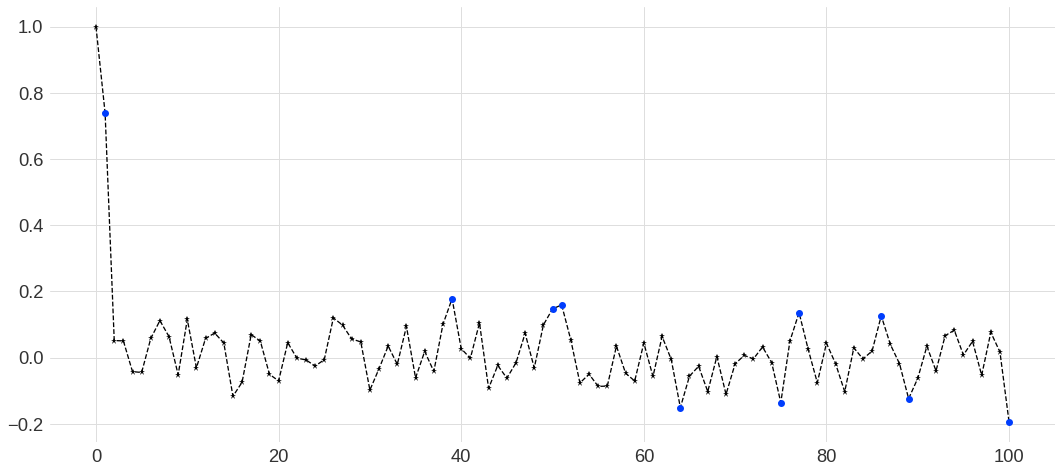

In [72]:
lags = estimateSignificantLags(get_input_item(item_id='FOODS_3_090').sales, significantLags = 10)
# add lags for certain days
lags = np.unique(np.hstack([lags]))
print(np.sort(lags))

## Building prediction models

In [73]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=1)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates,
                             model_display_name, 
                             future_covs=False):

    horizon = 1
    
    if future_covs == False:
        print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              start=60, 
                                              last_points_only=False, 
                                              overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              future_covariates=future_covariates,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*7)]
    else:
        return res_df
    #return res_df

In [74]:
"""input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), value_cols=['sales'])
future = TimeSeries.from_dataframe(get_input_item('FOODS_3_090'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
input_train, _ = input_timeseries.split_before(0.33)

naive_model_weekly = NaiveSeasonal(K=1)
naive_model_weekly.fit(input_train)

get_historical_forecasts(naive_model_weekly,
                         input_timeseries=input_timeseries,
                         model_display_name = naive_model_weekly,
                         future_covariates=future,
                         future_covs = False)"""

"input_timeseries = TimeSeries.from_dataframe(get_input_item('FOODS_3_090').set_index('date'), value_cols=['sales'])\nfuture = TimeSeries.from_dataframe(get_input_item('FOODS_3_090'), \n                                       value_cols=['sin_wday','cos_wday','special_events'])\ninput_train, _ = input_timeseries.split_before(0.33)\n\nnaive_model_weekly = NaiveSeasonal(K=1)\nnaive_model_weekly.fit(input_train)\n\nget_historical_forecasts(naive_model_weekly,\n                         input_timeseries=input_timeseries,\n                         model_display_name = naive_model_weekly,\n                         future_covariates=future,\n                         future_covs = False)"

In [75]:
def create_forecast_for_item(itemid):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), value_cols=['sales'])

    future = TimeSeries.from_dataframe(get_input_item(itemid).set_index('date'), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
    
    print(future)
    # We first set aside the first 33% as training series:
    input_train, _ = input_timeseries.split_before(0.33)

    naive_model_weekly = NaiveSeasonal(K=7)
    naive_model_weekly.fit(input_train)

    regr_model_lags =  RegressionModel(lags=[-1,-39,-50,-51])
    regr_model_lags.fit(input_train)

    regr_model_cov = RegressionModel(lags=[-1,-2,-5,-6,-7],
                                     lags_future_covariates=[-14,-7,-2,-5,-1,0,1,2,5,7])
    regr_model_cov.fit(input_train,future_covariates=future)

    lgbm_model_cov = LightGBMModel(lags=list(range(-14,0)),
                                   lags_future_covariates=[0,1,2,3,4,5,6,7],
                                   boosting_type='gbdt', 
                                   num_leaves=20, 
                                   max_depth=- 1, 
                                   learning_rate=0.01, 
                                   n_estimators=300)
    
    lgbm_model_cov.fit(input_train,
                       future_covariates=future)

    lgbm_model = LightGBMModel(lags=[-1,-2,-5,-6,-7],
                               boosting_type='gbdt', 
                               num_leaves=20, 
                               max_depth=- 1, 
                               learning_rate=0.01, 
                               n_estimators=300)
    
    lgbm_model.fit(input_train)
    
    theta_model =  Theta(2, 
                         seasonality_period=7, 
                         season_mode=SeasonalityMode.MULTIPLICATIVE)
    
    theta_model.fit(input_train)
    
    fft_model =  FFT(nr_freqs_to_keep=7, 
                     required_matches=set(), 
                     trend='exp')

    fft_model.fit(input_train)
    
    #arima_model = ARIMA(p=1, d=1, q=1, seasonal_order=(1, 7, 0, 0), random_state=0)
    
    #arima_model.fit(input_train)
    
    models = {'Naive weekly':[naive_model_weekly,False],
              'RegressionModelLags':[regr_model_lags,False],
              'RegressionModelCov':[regr_model_cov,True],
              'LGBM_cov':[lgbm_model_cov,True],
              'LGBM_no_cov':[lgbm_model,False],
              'Theta':[theta_model,False],
              'FFT':[fft_model,False],
              #'ARIMA':[arima_model,False]
             }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates=future,
                                                             future_covs = models[model][1]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [76]:
optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


In [77]:
optimization_df

ts        value prediction_date         model      item_id
0  2012-03-26  2080.000000      2012-03-26  Naive weekly  FOODS_3_555
0  2012-04-02  2347.000000      2012-04-02  Naive weekly  FOODS_3_555
0  2012-04-09  1769.000000      2012-04-09  Naive weekly  FOODS_3_555
0  2012-04-16  1850.000000      2012-04-16  Naive weekly  FOODS_3_555
0  2012-04-23  2168.000000      2012-04-23  Naive weekly  FOODS_3_555
..        ...          ...             ...           ...          ...
0  2016-04-04  2462.447191      2016-04-04           FFT  FOODS_3_586
0  2016-04-11  2477.265982      2016-04-11           FFT  FOODS_3_586
0  2016-04-18  2365.251129      2016-04-18           FFT  FOODS_3_586
0  2016-04-25  2329.303323      2016-04-25           FFT  FOODS_3_586
0  2016-05-02  2441.325394      2016-05-02           FFT  FOODS_3_586

[4515 rows x 5 columns]

In [79]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data_subset.reset_index().set_index(['date','item_id'])['sales']
#fact.loc[:,'FOODS_3_090',:].head()

In [80]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data_subset.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [81]:
alt.Chart(optimization_df).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    tooltip=['model:N','prediction_date:T','value:Q'],
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

In [82]:
'''alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df.reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N',
    column='item_id:N'
).properties(width=200, height=150)#.interactive()'''

"alt.data_transformers.disable_max_rows()\n\nalt.Chart(optimization_df.reset_index()).mark_line().encode(\n    x='ts:T',\n    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),\n    color=alt.Color('prediction_date:N', legend=None),\n    row='model:N',\n    column='item_id:N'\n).properties(width=200, height=150)#.interactive()"

### Evaluation function for all item_ids

In [83]:
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rmse_normalized'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rmse_normalized','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

model        rmse rmse_normalized      item_id
0          Naive weekly  281.263792             1.0  FOODS_3_555
1   RegressionModelLags  189.875868        0.675081  FOODS_3_555
2    RegressionModelCov  196.024531        0.696942  FOODS_3_555
3              LGBM_cov  213.974251         0.76076  FOODS_3_555
4           LGBM_no_cov  208.192813        0.740205  FOODS_3_555
5                 Theta  193.076645        0.686461  FOODS_3_555
6                   FFT  356.342921        1.266935  FOODS_3_555
7                  Fact         0.0             0.0  FOODS_3_555
8          Naive weekly  448.012178             1.0  FOODS_3_252
9   RegressionModelLags  227.812964        0.508497  FOODS_3_252
10   RegressionModelCov  229.568123        0.512415  FOODS_3_252
11             LGBM_cov  247.163436        0.551689  FOODS_3_252
12          LGBM_no_cov  254.539732        0.568154  FOODS_3_252
13                Theta  244.909882        0.546659  FOODS_3_252
14                  FFT  472.948225        1.055659  FOODS_3_252
15                 Fact         0.0             0.0  FOODS_3_252
16         Naive weekly  544.294102             1.0  FOODS_3_586
17  RegressionModelLags  313.885922        0.576684  FOODS_3_586
18   RegressionModelCov  332.367109        0.610639  FOODS_3_586
19             LGBM_cov  345.369593        0.634528  FOODS_3_586
20          LGBM_no_cov  335.079784        0.615623  FOODS_3_586
21                Theta  337.444716        0.619968  FOODS_3_586
22                  FFT  577.267184         1.06058  FOODS_3_586
23                 Fact         0.0             0.0  FOODS_3_586

In [84]:
alt.Chart(eval_df, title = 'RMSE for items, by model').mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

In [85]:
(eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/3).reset_index()

model  rmse_normalized        rmse
0                  FFT         1.127725  468.852777
1                 Fact         0.000000    0.000000
2             LGBM_cov         0.648992  268.835760
3          LGBM_no_cov         0.641327  265.937443
4         Naive weekly         1.000000  424.523358
5   RegressionModelCov         0.606665  252.653254
6  RegressionModelLags         0.586754  243.858251
7                Theta         0.617696  258.477081

In [87]:
alt.Chart((eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/3).reset_index(),
         title='Average RMSE for all items, by model').mark_bar().encode(
    x=alt.X('model:N'),
    y=alt.Y('rmse:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [88]:
items_prices = data_subset.loc[data_subset.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)

optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price
optimization_df

item_id         ts   value prediction_date         model  \
0     FOODS_3_555 2012-03-26  2080.0      2012-03-26  Naive weekly   
1     FOODS_3_555 2012-04-02  2347.0      2012-04-02  Naive weekly   
2     FOODS_3_555 2012-04-09  1769.0      2012-04-09  Naive weekly   
3     FOODS_3_555 2012-04-16  1850.0      2012-04-16  Naive weekly   
4     FOODS_3_555 2012-04-23  2168.0      2012-04-23  Naive weekly   
...           ...        ...     ...             ...           ...   
5155  FOODS_3_586 2016-04-04  2680.0      2016-04-04          Fact   
5156  FOODS_3_586 2016-04-11  3007.0      2016-04-11          Fact   
5157  FOODS_3_586 2016-04-18  2816.0      2016-04-18          Fact   
5158  FOODS_3_586 2016-04-25  2875.0      2016-04-25          Fact   
5159  FOODS_3_586 2016-05-02  2809.0      2016-05-02          Fact   

      sell_price  daily_revenue  
0       1.595887    3319.443972  
1       1.595887    3745.545674  
2       1.595887    2823.123262  
3       1.595887    2952.390071  
4       1.595887    3459.881986  
...          ...            ...  
5155    1.595922    4277.070922  
5156    1.595922    4798.937411  
5157    1.595922    4494.116312  
5158    1.595922    4588.275709  
5159    1.595922    4482.944858  

[5160 rows x 7 columns]

In [89]:
#weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = optimization_df.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [90]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

### Optimization target:
* Every week we make predictions for each item and calculate total profit for the week
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price
* We implement a discounts for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount

* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [91]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 1
        self.DECISION_TIMESTEP = 1
        self.MAX_CAPACITY = (data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        self.BASIC_PRICES = items_prices
        #self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits):
        
        capacity_penalty = 1
        #w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, data=solution*3, columns=['value_increase']) #2% increase in sales for each 1% increase in discount
        

        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*.4)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*.4)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast 

        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data['prediction_date'].unique()

        recommendation = pd.DataFrame()
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=1000)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])


            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [92]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [93]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed: 35.9min remaining: 107.6min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 36.2min remaining: 60.3min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 36.4min remaining: 36.4min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed: 36.8min remaining: 22.1min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 36.8min remaining: 12.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 37.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 37.1min finished


In [94]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

## Evaluation of optimization based on Fact values

In [95]:
result_df.head()

model      item_id prediction_date         ts   value  sell_price  \
0  Naive weekly  FOODS_3_555      2012-03-26 2012-03-26  2080.0    1.595887   
1  Naive weekly  FOODS_3_252      2012-03-26 2012-03-26  1682.0    1.520355   
2  Naive weekly  FOODS_3_586      2012-03-26 2012-03-26  3864.0    1.595922   
3  Naive weekly  FOODS_3_555      2012-04-02 2012-04-02  2347.0    1.595887   
4  Naive weekly  FOODS_3_252      2012-04-02 2012-04-02  1815.0    1.520355   

   daily_revenue  disount  sell_price_w_disount  value_increase  \
0    3319.443972      0.1              1.436298             0.3   
1    2557.236454      0.1              1.368319             0.3   
2    6166.642553      0.1              1.436330             0.3   
3    3745.545674      0.1              1.436298             0.3   
4    2759.443617      0.1              1.368319             0.3   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0           2704.0              3883.749447   1991.666383   
1           2186.6              2991.966651   1534.341872   
2           5023.2              7214.971787   3699.985532   
3           3051.1              4382.288438   2247.327404   
4           2359.5              3228.549032   1655.666170   

   daily_profit_w_disount  
0             2157.638582  
1             1662.203695  
2             4008.317660  
3             2434.604688  
4             1793.638351

In [96]:
result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*.4)

## Inventory:
 * After predicting the demand N with discount we'll buy 1.1*N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40%) is being deducted from the final profit

In [97]:
#result_weekly = result_df.groupby(['item_id','model','prediction_date']).sum()
#result_weekly[['sell_price','disount','sell_price_w_disount','value_increase']] = result_df.groupby(['item_id','model','prediction_date']).max()[['sell_price','disount','sell_price_w_disount','value_increase']]
result_df['inventory_left'] = 1.1*result_df['value_w_disount'] - result_df['value_w_disount_fact'] 
result_df['final_profit_w_discount'] = result_df['daily_profit_w_disount_fact']
result_df['final_profit_base_price'] = result_df['daily_profit_fact']


# if inventory_left>0 substract 40% of it's price from profits
result_df.loc[result_df.inventory_left>0,'final_profit_w_discount']  = result_df.loc[result_df.inventory_left>0,'daily_profit_w_disount_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4
result_df.loc[result_df.inventory_left>0,'final_profit_base_price']  = result_df.loc[result_df.inventory_left>0,'daily_profit_fact'] - result_df.loc[result_df.inventory_left>0,'inventory_left']*result_df.loc[result_df.inventory_left>0,'sell_price']*.4

# if inventory_lef<0 substract all additional items that we weren't able to sell
result_df.loc[result_df.inventory_left<0,'final_profit_w_discount'] = result_df.loc[result_df.inventory_left<0,'daily_profit_w_disount_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price_w_disount']
result_df.loc[result_df.inventory_left<0,'final_profit_base_price'] = result_df.loc[result_df.inventory_left<0,'daily_profit_fact'] + result_df.loc[result_df.inventory_left<0,'inventory_left']*result_df.loc[result_df.inventory_left<0,'sell_price']

result_df.head()

item_id prediction_date         ts                model        value  \
0  FOODS_3_252      2012-03-26 2012-03-26         Naive weekly  1682.000000   
1  FOODS_3_252      2012-03-26 2012-03-26  RegressionModelLags  1899.631153   
2  FOODS_3_252      2012-03-26 2012-03-26   RegressionModelCov  2105.375175   
3  FOODS_3_252      2012-03-26 2012-03-26             LGBM_cov  2203.102564   
4  FOODS_3_252      2012-03-26 2012-03-26          LGBM_no_cov  1948.704324   

   sell_price  daily_revenue  disount  sell_price_w_disount  value_increase  \
0    1.520355    2557.236454      0.1              1.368319             0.3   
1    1.520355    2888.112981      0.1              1.368319             0.3   
2    1.520355    3200.916853      0.1              1.368319             0.3   
3    1.520355    3349.497139      0.0              1.520355             0.0   
4    1.520355    2962.721603      0.1              1.368319             0.3   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0      2186.600000              2991.966651   1534.341872   
1      2469.520499              3379.092188   1732.867789   
2      2736.987727              3745.072718   1920.550112   
3      2203.102564              3349.497139   2009.698284   
4      2533.315622              3466.384275   1777.632962   

   daily_profit_w_disount  value_fact  daily_profit_fact  \
0             1662.203695      1911.0        1743.238596   
1             1877.273438      1911.0        1743.238596   
2             2080.595954      1911.0        1743.238596   
3             2009.698284      1911.0        1743.238596   
4             1925.769042      1911.0        1743.238596   

   value_w_disount_fact  daily_profit_w_disount_fact  inventory_left  \
0                2484.3                  1888.508479      -79.040000   
1                2484.3                  1888.508479      232.172549   
2                2484.3                  1888.508479      526.386500   
3                1911.0                  1743.238596      512.412821   
4                2484.3                  1888.508479      302.347184   

   final_profit_w_discount  final_profit_base_price  
0              1780.356533              1623.069767  
1              1747.314636              1602.044753  
2              1568.390822              1423.120939  
3              1431.618918              1431.618918  
4              1704.638505              1559.368622

In [98]:
alt.data_transformers.disable_max_rows()

alt.Chart(result_df.reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('final_profit_w_discount:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

In [99]:
"""alt.Chart(result_df.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()"""

"alt.Chart(result_df.loc[:,['Fact','LGBM_cov'],:].reset_index()).mark_line().encode(\n    x='prediction_date:T',\n    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),\n    color=alt.Color('model:N'),\n    #row='model:N',\n    column='item_id:N'\n).properties(width=300, height=400)#.interactive()"

In [100]:
discounts_freq = result_df.reset_index().groupby(['model','disount']).count()['item_id'].reset_index()

alt.Chart(discounts_freq).mark_bar().encode(
    x='model:N',
    y=alt.Y('item_id:Q'),
    color=alt.Color('model:N'),
    #row='model:N',
    column='disount:N'
).properties(width=80, height=400)#.interactive()

alt.Chart(...)

In [101]:
result_df

item_id prediction_date         ts                model  \
0     FOODS_3_252      2012-03-26 2012-03-26         Naive weekly   
1     FOODS_3_252      2012-03-26 2012-03-26  RegressionModelLags   
2     FOODS_3_252      2012-03-26 2012-03-26   RegressionModelCov   
3     FOODS_3_252      2012-03-26 2012-03-26             LGBM_cov   
4     FOODS_3_252      2012-03-26 2012-03-26          LGBM_no_cov   
...           ...             ...        ...                  ...   
5155  FOODS_3_586      2016-05-02 2016-05-02             LGBM_cov   
5156  FOODS_3_586      2016-05-02 2016-05-02          LGBM_no_cov   
5157  FOODS_3_586      2016-05-02 2016-05-02                Theta   
5158  FOODS_3_586      2016-05-02 2016-05-02                  FFT   
5159  FOODS_3_586      2016-05-02 2016-05-02                 Fact   

            value  sell_price  daily_revenue  disount  sell_price_w_disount  \
0     1682.000000    1.520355    2557.236454      0.1              1.368319   
1     1899.631153    1.520355    2888.112981      0.1              1.368319   
2     2105.375175    1.520355    3200.916853      0.1              1.368319   
3     2203.102564    1.520355    3349.497139      0.0              1.520355   
4     1948.704324    1.520355    2962.721603      0.1              1.368319   
...           ...         ...            ...      ...                   ...   
5155  2961.953137    1.595922    4727.046132      0.1              1.436330   
5156  3034.429220    1.595922    4842.712306      0.1              1.436330   
5157  2938.162924    1.595922    4689.078808      0.1              1.436330   
5158  2441.325394    1.595922    3896.164871      0.1              1.436330   
5159  2809.000000    1.595922    4482.944858      0.1              1.436330   

      value_increase  value_w_disount  daily_revenue_w_disount  daily_profit  \
0                0.3      2186.600000              2991.966651   1534.341872   
1                0.3      2469.520499              3379.092188   1732.867789   
2                0.3      2736.987727              3745.072718   1920.550112   
3                0.0      2203.102564              3349.497139   2009.698284   
4                0.3      2533.315622              3466.384275   1777.632962   
...              ...              ...                      ...           ...   
5155             0.3      3850.539078              5530.643974   2836.227679   
5156             0.3      3944.757985              5665.973398   2905.627384   
5157             0.3      3819.611801              5486.222206   2813.447285   
5158             0.3      3173.723012              4558.512899   2337.698922   
5159             0.3      3651.700000              5245.045484   2689.766915   

      daily_profit_w_disount  value_fact  daily_profit_fact  \
0                1662.203695      1911.0        1743.238596   
1                1877.273438      1911.0        1743.238596   
2                2080.595954      1911.0        1743.238596   
3                2009.698284      1911.0        1743.238596   
4                1925.769042      1911.0        1743.238596   
...                      ...         ...                ...   
5155             3072.579986      2809.0        2689.766915   
5156             3147.762999      2809.0        2689.766915   
5157             3047.901225      2809.0        2689.766915   
5158             2532.507166      2809.0        2689.766915   
5159             2913.914158      2809.0        2689.766915   

      value_w_disount_fact  daily_profit_w_disount_fact  inventory_left  \
0                   2484.3                  1888.508479      -79.040000   
1                   2484.3                  1888.508479      232.172549   
2                   2484.3                  1888.508479      526.386500   
3                   1911.0                  1743.238596      512.412821   
4                   2484.3                  1888.508479      302.347184   
...                    ...                          ...         

In [102]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = (result_df.groupby(['model','item_id']).sum()['final_profit_w_discount'] \
                                - result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']) \
                                /result_df.groupby(['model','item_id']).sum().loc['Fact','final_profit_base_price']
eval_df.reset_index(inplace=True)

In [103]:
alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

## Evaluation for all items in total

In [104]:
all_items_eval = result_df.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.loc['Fact','final_profit_base_price'])/all_items_eval.loc['Fact','final_profit_base_price']
all_items_eval['disount'] = result_df.groupby('model').mean()['disount']


<AxesSubplot:ylabel='Frequency'>

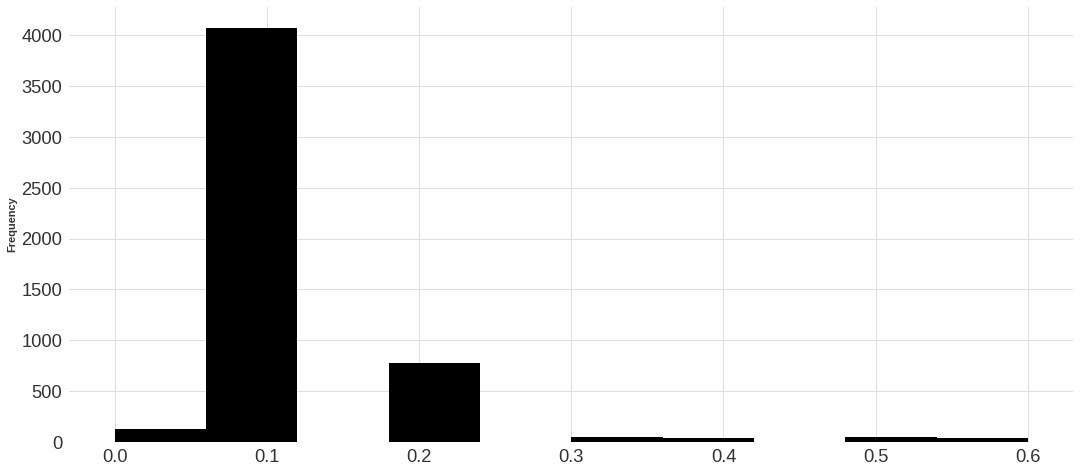

In [105]:
result_df['disount'].plot.hist()

In [106]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=True),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [107]:
eval_df[['rmse','rmse_normalized']] = eval_df[['rmse','rmse_normalized']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rmse_normalized']] = eval_df.groupby('model').mean()[['rmse','rmse_normalized']]

In [108]:
all_items_eval

value   sell_price  daily_revenue   disount  \
model                                                                     
FFT                  1.269303e+06  1013.115071   1.997962e+06  0.124186   
Fact                 1.508112e+06  1013.115071   2.373261e+06  0.130233   
LGBM_cov             1.544082e+06  1013.115071   2.430588e+06  0.125736   
LGBM_no_cov          1.540555e+06  1013.115071   2.424904e+06  0.126357   
Naive weekly         1.514545e+06  1013.115071   2.383635e+06  0.123876   
RegressionModelCov   1.545010e+06  1013.115071   2.432063e+06  0.117829   
RegressionModelLags  1.511573e+06  1013.115071   2.379044e+06  0.125116   
Theta                1.510098e+06  1013.115071   2.376456e+06  0.121395   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
FFT                            887.338110           240.3     1.738447e+06   
Fact                           881.121716           252.0     2.082166e+06   
LGBM_cov                       885.651535           243.3     2.125018e+06   
LGBM_no_cov                    885.050975           244.5     2.120163e+06   
Naive weekly                   887.611950           239.7     2.072707e+06   
RegressionModelCov             893.722621           228.0     2.093552e+06   
RegressionModelLags            886.441007           242.1     2.075636e+06   
Theta                          890.104965           234.9     2.058065e+06   

                     daily_revenue_w_disount  daily_profit  \
model                                                        
FFT                             2.370172e+06  1.198777e+06   
Fact                            2.813896e+06  1.423957e+06   
LGBM_cov                        2.887996e+06  1.458353e+06   
LGBM_no_cov                     2.874796e+06  1.454943e+06   
Naive weekly                    2.827999e+06  1.430181e+06   
RegressionModelCov              2.884406e+06  1.459238e+06   
RegressionModelLags             2.813967e+06  1.427426e+06   
Theta                           2.811723e+06  1.425874e+06   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
FFT                            1.275688e+06   1508112.0       1.423957e+06   
Fact                           1.503184e+06   1508112.0       1.423957e+06   
LGBM_cov                       1.549764e+06   1508112.0       1.423957e+06   
LGBM_no_cov                    1.539818e+06   1508112.0       1.423957e+06   
Naive weekly                   1.523180e+06   1508112.0       1.423957e+06   
RegressionModelCov             1.566145e+06   1508112.0       1.423957e+06   
RegressionModelLags            1.507457e+06   1508112.0       1.423957e+06   
Theta                          1.516101e+06   1508112.0       1.423957e+06   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
FFT                             2066156.1                 1.514576e+06   
Fact                            2082165.9                 1.503184e+06   
LGBM_cov                        2073107.1                 1.514615e+06   
LGBM_no_cov                     2078349.6                 1.505695e+06   
Naive weekly                    2066007.9                 1.516079e+06   
RegressionModelCov              2046305.7                 1.527277e+06   
RegressionModelLags             2068877.7                 1.504530e+06   
Theta                           2055297.6                 1.514114e+06   

                     inventory_left  final_profit_w_discount  \
model                                                          
FFT                  -153864.373060             1.221914e+06   
Fact                  208216.590000             1.372113e+06   
LGBM_cov              264412.928644             1.312894e+06   
LGBM_no_cov           253829.6195

In [109]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + fact_line

alt.LayerChart(...)

In [110]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

alt.Chart(...)

In [111]:
all_items_eval

value   sell_price  daily_revenue   disount  \
model                                                                     
FFT                  1.269303e+06  1013.115071   1.997962e+06  0.124186   
Fact                 1.508112e+06  1013.115071   2.373261e+06  0.130233   
LGBM_cov             1.544082e+06  1013.115071   2.430588e+06  0.125736   
LGBM_no_cov          1.540555e+06  1013.115071   2.424904e+06  0.126357   
Naive weekly         1.514545e+06  1013.115071   2.383635e+06  0.123876   
RegressionModelCov   1.545010e+06  1013.115071   2.432063e+06  0.117829   
RegressionModelLags  1.511573e+06  1013.115071   2.379044e+06  0.125116   
Theta                1.510098e+06  1013.115071   2.376456e+06  0.121395   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
FFT                            887.338110           240.3     1.738447e+06   
Fact                           881.121716           252.0     2.082166e+06   
LGBM_cov                       885.651535           243.3     2.125018e+06   
LGBM_no_cov                    885.050975           244.5     2.120163e+06   
Naive weekly                   887.611950           239.7     2.072707e+06   
RegressionModelCov             893.722621           228.0     2.093552e+06   
RegressionModelLags            886.441007           242.1     2.075636e+06   
Theta                          890.104965           234.9     2.058065e+06   

                     daily_revenue_w_disount  daily_profit  \
model                                                        
FFT                             2.370172e+06  1.198777e+06   
Fact                            2.813896e+06  1.423957e+06   
LGBM_cov                        2.887996e+06  1.458353e+06   
LGBM_no_cov                     2.874796e+06  1.454943e+06   
Naive weekly                    2.827999e+06  1.430181e+06   
RegressionModelCov              2.884406e+06  1.459238e+06   
RegressionModelLags             2.813967e+06  1.427426e+06   
Theta                           2.811723e+06  1.425874e+06   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
FFT                            1.275688e+06   1508112.0       1.423957e+06   
Fact                           1.503184e+06   1508112.0       1.423957e+06   
LGBM_cov                       1.549764e+06   1508112.0       1.423957e+06   
LGBM_no_cov                    1.539818e+06   1508112.0       1.423957e+06   
Naive weekly                   1.523180e+06   1508112.0       1.423957e+06   
RegressionModelCov             1.566145e+06   1508112.0       1.423957e+06   
RegressionModelLags            1.507457e+06   1508112.0       1.423957e+06   
Theta                          1.516101e+06   1508112.0       1.423957e+06   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
FFT                             2066156.1                 1.514576e+06   
Fact                            2082165.9                 1.503184e+06   
LGBM_cov                        2073107.1                 1.514615e+06   
LGBM_no_cov                     2078349.6                 1.505695e+06   
Naive weekly                    2066007.9                 1.516079e+06   
RegressionModelCov              2046305.7                 1.527277e+06   
RegressionModelLags             2068877.7                 1.504530e+06   
Theta                           2055297.6                 1.514114e+06   

                     inventory_left  final_profit_w_discount  \
model                                                          
FFT                  -153864.373060             1.221914e+06   
Fact                  208216.590000             1.372113e+06   
LGBM_cov              264412.928644             1.312894e+06   
LGBM_no_cov           253829.6195